In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchtext.data import Field, BucketIterator
import torchtext

import spacy

import sys, os, io, random, math
import time
import numpy as np
import pandas as pd
from jupyterplot import ProgressPlot
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

# Tokenizer Setup
I am using spaCy to tokenize since it's a little more robust than the default pytorch tokenizer
Seq2Seq reverses the input sentences, but since this techincally is more semantic analysis
than sequence to sequence, we're going to leave it in the forward order.

In [5]:
spacy_en = spacy.load('en')

In [6]:
def tokenize_input_lang(text):
    '''
    Tokenize input from a string into a list of tokens and reverses it
    '''
    return [tok.text for tok in spacy_en.tokenizer(text)]


## Fields setup

In [7]:
def stoi(x):
    return [int(x[0])]

TEXT = Field(tokenize = tokenize_input_lang, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

LABEL = Field(dtype = torch.int, use_vocab=False, is_target=True, preprocessing=stoi)
ID = Field(dtype = torch.int, use_vocab=False, preprocessing=stoi)
# The original file contains: id    keyword    location    target
# However I haven't decided how I want to include the keywords in this model yet (probably concatentaiton)
# So for now it is being trained without
#
# To train with
fields = [('id', ID), (None, None), (None,None), ('text', TEXT), ('label', LABEL)]

/home/janelle/software/miniconda2/envs/chris/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


# Importing and Loading Data To Use In PyTorch

In [8]:
twitter_dataset = torchtext.data.TabularDataset('train.csv','csv',fields,skip_header=True)

/home/janelle/software/miniconda2/envs/chris/lib/python3.7/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/janelle/software/miniconda2/envs/chris/lib/python3.7/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [10]:
# torchtext.data.split() returns default a 70-30 split for training-testin
# but since testing is provided by kaggle we will treat this as our 
# training-validation split
train_data, valid_data = twitter_dataset.split()

## Double check we've loaded the right number and split correctly

In [11]:
print(f"Number of total examples: {len(twitter_dataset.examples)}")
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")

Number of total examples: 7613
Number of training examples: 5329
Number of validation examples: 2284


## Example of one of the training data (Tokenized correctly and reversed (?) )

In [12]:
print(vars(train_data.examples[1]))
print(type(vars(train_data.examples[1])['label'][0]))

{'id': [5647], 'text': ['@crabbycale', 'oh', 'my', 'god', 'the', 'memories', 'are', 'flooding', 'back'], 'label': [0]}
<class 'int'>


## Slang Embeddings setup

In [13]:
# def load_embeddings(fname):
#     fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
#     n, d = map(int, fin.readline().split())
#     data = {}
#     for line in fin:
#         tokens = line.rstrip().split(' ')
#         data[tokens[0]] = list(map(float, tokens[1:]))
#     return data

# slang_emb = load_embeddings('ud_embeddings/ud_basic.vec')
slang_emb = torchtext.vocab.Vectors(name = '../chris_nlp_data/ud_embeddings/ud_basic.vec',
                                   cache = '../chris_nlp_data/ud_embeddings',
                                   unk_init = torch.Tensor.normal_)

### Some helpful functions to verify things are working correctly

Next block from https://colab.research.google.com/github/bentrevett/pytorch-sentiment-analysis/blob/master/B%20-%20A%20Closer%20Look%20at%20Word%20Embeddings.ipynb#scrollTo=DMkoy7iFMeN3

In [14]:
def get_vector(embeddings, word):
    assert word in embeddings.stoi, f'*{word}* is not in the vocab!'
    return embeddings.vectors[embeddings.stoi[word]]

def closest_words(embeddings, vector, n = 10):
    
    distances = [(word, torch.dist(vector, get_vector(embeddings, word)).item())
                 for word in embeddings.itos]
    
    return sorted(distances, key = lambda w: w[1])[:n]

def print_tuples(tuples):
    for w, d in tuples:
        print(f'({d:02.04f}) {w}') 
        

def analogy(embeddings, word1, word2, word3, n=5):
    
    #get vectors for each word
    word1_vector = get_vector(embeddings, word1)
    word2_vector = get_vector(embeddings, word2)
    word3_vector = get_vector(embeddings, word3)
    
    #calculate analogy vector
    analogy_vector = word2_vector - word1_vector + word3_vector
    
    #find closest words to analogy vector
    candidate_words = closest_words(embeddings, analogy_vector, n+3)
    
    #filter out words already in analogy
    candidate_words = [(word, dist) for (word, dist) in candidate_words 
                       if word not in [word1, word2, word3]][:n]
    
    print(f'{word1} is to {word2} as {word3} is to...')
    
    return candidate_words

In [15]:
# print_tuples(analogy(slang_emb, 'man', 'actor', 'woman'))

## Build Vocab

In [16]:
TEXT.build_vocab(twitter_dataset,
                vectors = slang_emb)
LABEL.build_vocab(train_data)

In [17]:
print(f"Unique tokens in text vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in label vocabulary: {len(LABEL.vocab)}")

Unique tokens in text vocabulary: 22637
Unique tokens in label vocabulary: 4


In [18]:
print(LABEL.vocab.freqs)
print(LABEL.vocab.itos)

Counter({0: 3042, 1: 2287})
['<unk>', '<pad>', 0, 1]


In [19]:
b = TEXT.vocab.vectors[TEXT.vocab.stoi['man']]
a = get_vector(slang_emb,'man')
print (a - b)
# If loaded correctly all should be 0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

# Hyper-Parameters

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 52

## Iterator setup

In [21]:
train_iterator, valid_iterator = BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE,
    device = device,
    sort_key = lambda x: len(x.text),
    sort_within_batch=False)

/home/janelle/software/miniconda2/envs/chris/lib/python3.7/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [22]:
# print(train_iterator.itos)

# Model setup

Encoder from LSTM (Context vectors) + fully connected layer to predict sentiment

The Encoder is based on Sew2Seq tutorial https://colab.research.google.com/github/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb#scrollTo=Ao4yzOdnyv8s. 

Much of this math and logic will come from there

## Encoder

preprocessingWe're going to use a 2 layer LSTM for our encoder. If I have time I would like to do like Seq2Seq and do a 4 layer

### Starting with simple RNN structure

Consider the input sequence $X$ where $x_t \in X$ is the input token to the first encoder layer at time t, and the hidden states $H = \{h_1, h_2, ..., h_T\}$ are the output a hidden layer. Also let $e(x)$ represent the embedding of the input token $x$. Then with superscripts representing the layer, we can consider our input functions as

$$h_t^1 = \text{EncoderRNN}^1(e(x_t),h^1_{t-1})$$
and
$$h_t^2 = \text{EncoderRNN}^2(h^1_t,h^2_{t-1})$$

Let the initial hidden state as input for each layer be $h_0^l$ and the final context vector per layer be $z^l = h_T^l$

### Transforming into LSTM

We think about LSTM's being simple extensions from RNN's by adding an extra cell state an extra 'hidden state', although they have different functions. We denote this $c_t^l$ Our simple input function:

$$h_t = \text{RNN}(e(x_t), h_{t-1})$$

can then be transformed into

$$ (h_t, c_t) = \text{LSTM}(e(x_t), h_{t-1}, c_{t-1})$$

We'll also need an initial cell state $c_0^l$ and we will transform our context-vector/final-hidden-state to be the tupple $z^l = (h_T^l, c_T^l)$.

By extension to two layers then we have 

$$\begin{align*}
(h_t^1, c_t^1) &= \text{EncoderLSTM}^1(e(x_t), (h_{t-1}^1, c_{t-1}^1))\\
(h_t^2, c_t^2) &= \text{EncoderLSTM}^2(h_t^1, (h_{t-1}^2, c_{t-1}^2))
\end{align*}$$


In [23]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

## Fully Connected

Small fully connected layer to help with encapsulation

In [24]:
class FullyConnected(nn.Module):
    def __init__(self, input_dim, intermediate_dim, output_dim):
        super().__init__()
        self.fc_in = nn.Linear(input_dim, intermediate_dim)
        self.activation = nn.functional.relu
        self.fc_out = nn.Linear(intermediate_dim, output_dim)
    
    def forward(self, input_x):
        
        x = self.fc_in(input_x.squeeze(0))
        x = self.activation(x)
        x = self.fc_out(x)
        return x

## Model class

In [25]:
class CustomModel(nn.Module):
    def __init__(self, encoder, fc, device):
        super().__init__()
        
        self.encoder = encoder
        self.fc = fc
        self.device = device
        
    def forward(self, src):
        
        hidden, cell = self.encoder(src)
        fc_input = torch.cat((hidden[0],hidden[1],cell[0],cell[1]),1)
        output = self.fc(fc_input)
       
        return output
     
        
        
        

#### Instantiate everything

In [26]:
INPUT_DIM = len(TEXT.vocab)
OUTPUT_DIM =  len(LABEL.vocab) - 2
ENC_EMB_DIM = 300
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5

FC_IN_DIM = HID_DIM * N_LAYERS * 2 # CELL and HIDDEN for each layer
INTERMEDIATE_DIM = 128 # See what works best here

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
fc = FullyConnected(FC_IN_DIM,INTERMEDIATE_DIM,OUTPUT_DIM)

embed_weights = TEXT.vocab.vectors
enc.embedding.weight.data.copy_(embed_weights)
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

enc.embedding.weight.data[UNK_IDX] = torch.zeros(ENC_EMB_DIM)
enc.embedding.weight.data[PAD_IDX] = torch.zeros(ENC_EMB_DIM)

#freeze embeddings
enc.embedding.weight.requires_grad = False

model = CustomModel(enc,fc, device ).to(device)

## Initialize weights

We're going to initialize all weights from a uniform distribution between -0.08 and +0.08 (like in the seq2seq paper)


In [27]:
# def init_weights(m):
#     for name, param in m.named_parameters():
#         nn.init.uniform_(param.data, -0.08, 0.08)
        
# model.apply(init_weights)

Info about the number of trainable parameters

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,030,850 trainable parameters


Using Adam optimizer

In [29]:
optimizer = optim.Adam(model.parameters())

# Define Loss function
Could use squared loss but going to use cross-entropy loss for nowinputs

In [246]:
#def loss_fn(self, label, predicted):
#    return (label - predicted )^2
criterion = nn.CrossEntropyLoss().to(device)

np.sin(i / 100)# Training loop
At each iteration:
 - get tweet and label, $X$ and $Y$
 - zero gradients calculated from the last batch
 - feed the tweet and label into the model to get output $\hat{y}$
 - flatten inputs with `.view` since loss function works with 2d inputsand 1d target
 - calculate the gradients with `loss.backward()`
 - clip the gradient to prevent explosion
 - update parameters with optimizer step
 - sum loss into running total
 
Once done, return average loss

In [275]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
#         print(batch)
        src = batch.text
#         print("src",batch.text[:,0])
        trg = batch.label
#         print("trg",batch.label)
        optimizer.zero_grad()
        
        output = model(src)
#         print(trg[0,0])
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
#         print(output.shape)
#         print(trg.shape)
#         print(output)
#         print("target")
#         print(trg)
        output_dim = output.shape[-1]
#         print(output_dim)
        output = output.view(-1, output_dim)
        trg = trg.view(-1)
#         print(len(trg))
        trg = trg.long()
        #trg = [(trg len ) * batch size]
        #output = [(trg len ) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

# Evaluation loop

In [248]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.text
            trg = batch.label

            output = model(src)

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output.view(-1, output_dim)
            trg = trg.view(-1)
            trg = trg.long()
#             print(output[0].shape)
#             print(trg[0])
            #trg = [(trg len ) * batch size]
            #output = [(trg len ) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
         
    return epoch_loss / len(iterator)

Calculate how long an epoch takes

In [249]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Full training 

In [108]:
N_EPOCHS = 30
b_size = 52
dim = 256
file_name = str(N_EPOCHS)+"-epochs-"+str(b_size)+"-batch-"+str(dim)+"-dim-full-embed"
training_loss_data = []
validation_loss_data = []

In [ ]:
N_EPOCHS = 30
CLIP = 1
f = open("slang/log_data/"+file_name+".txt","w")
best_valid_loss = float('inf')
print("running")
pp = ProgressPlot(plot_names=['loss'],line_names=['training','validation'])

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    validation_loss_data.append(valid_loss)
    training_loss_data.append(train_loss)
    pp.update([[train_loss,valid_loss]])
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "slang/models/"+file_name+'.pt')
    
    f.write(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s\n')
    f.write(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}\n')
    f.write(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}\n')
f.close()
pp.finalize()


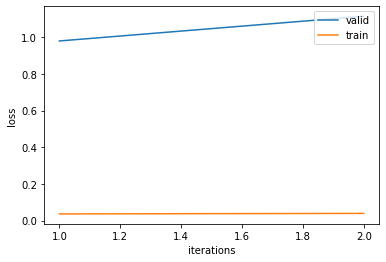

In [151]:
# print(training_loss_data)
x_data = []
for v in range(N_EPOCHS):
    x_data.append(v+1)
plt.plot(x_data,validation_loss_data)
plt.plot(x_data,training_loss_data)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend(['valid','train'], loc="upper right")
plt.savefig("loss_plots/"+file_name+'.png')

# Saving data for putting in a table later

In [36]:
f = open("loss_data/"+file_name+".txt", "w")
# write validation loss as an array
for loss in validation_loss_data:
    f.write(f'{loss:.3f}')
    f.write(', ')
f.write('\n')
# write train loss
for loss in training_loss_data:
    f.write(f'{loss:.3f}')
    f.write(', ')
f.write('\n')
f.close()

# Data verification

In [137]:
f = open("loss_data/"+file_name+".txt", "r")
s = f.readline()
s = s.split(', ')
s = s[:-1]
test_loss = []
for v in s:
    test_loss.append(float(v))
# print(validation_loss_data - test_loss)
test_loss = np.array(test_loss)
# print(test_loss)
old_loss = np.array(validation_loss_data)
print(old_loss - validation_loss_data)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


# Testing

In [250]:
model_name = '30-epochs-10-batch-128-dim'
model.load_state_dict(torch.load('new/slang/models/'+model_name+'.pt'))

# test_loss = evaluate(model, test_iterator, criterion)

# print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

<All keys matched successfully>

In [251]:
ID = Field(dtype = torch.int, use_vocab=False, preprocessing=stoi)
# The original file contains: id    keyword    location    target
# However I haven't decided how I want to include the keywords in this model yet (probably concatentaiton)
# So for now it is being trained without
#
# To train with
fields = [('id', ID), (None, None), (None,None), ('text', TEXT), (None, None)]
test_dataset = torchtext.data.TabularDataset('test.csv','csv',fields,skip_header=True)
test_iterator = BucketIterator(
    test_dataset, 
    batch_size = BATCH_SIZE,
    device = device,
    sort_key = lambda x: len(x.id),
    sort_within_batch=False)

/home/janelle/software/miniconda2/envs/chris/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/janelle/software/miniconda2/envs/chris/lib/python3.7/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/janelle/software/miniconda2/envs/chris/lib/python3.7/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon a

In [252]:
def test_evaluate(model, iterator):
    
    model.eval()
    
    epoch_loss = 0
    results = {}
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            
            src = batch.text
            number = batch.id
            
            output = model(src)
#             for word in src[:,0]:
#                 print(TEXT.vocab.itos[word.item()])
#             print(number[0][0].item())
#             print(number[0].shape[0])
            for j in range(number[0].shape[0]):
#                 print(output[i,:].cpu().numpy())
                results[number[0][j].item()] = output[j,:].cpu().numpy()
                
            
            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output.view(-1, output_dim)
            
            

            #trg = [(trg len ) * batch size]
            #output = [(trg len ) * batch size, output dim]
    return results


In [253]:
results = test_evaluate(model, test_iterator)

/home/janelle/software/miniconda2/envs/chris/lib/python3.7/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [254]:
final_results = {}
for key in results:
    final_results[key] = np.argmax(results[key])
# print(final_results)

In [298]:
# sorted_results = sorted(final_results.items(), key = lambda item: item[0])
# with open("slang_submission_2.csv","w") as f:
#     f.write('id,target\n')
#     for n,t in sorted_results:
#         f.write(str(n)+","+str(t)+'\n')

def getPrecision(model, iterator):
        
    model.eval()
    
    precision = 0
    true_pos = 0
    false_pos = 0
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            
            src = batch.text
            trg = batch.label
            
#             number = batch.id
            
            output = model(src)
#             for word in src[:,0]:
#                 print(TEXT.vocab.itos[word.item()])
#             print(number[0][0].item())
#             print(number[0].shape[0])
#             print(output.shape)
            for j in range(output.shape[0]):
#                 print(output[i,:].cpu().numpy())
#                 print(output.shape)
                predicted = np.argmax(output[j,:].cpu().numpy())
                expected = trg[0,j].item()
                # If it was negative
                if expected == 0:
                    # if false positive
                    if predicted == 1:
                        false_pos = false_pos +1
                
                # if it was positive
                elif expected == 1:
                    # if true pos
                    if predicted == 1:
                        true_pos = true_pos + 1
                
                
        precision = true_pos/(true_pos + false_pos)
                
                
            

            #trg = [(trg len ) * batch size]
            #output = [(trg len ) * batch size, output dim]
    return precision

def getRecall(model, iterator):
            
    model.eval()
    
    recall = 0
    true_pos = 0
    false_neg = 0
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            
            src = batch.text
            trg = batch.label
            
#             number = batch.id
            
            output = model(src)
#             for word in src[:,0]:
#                 print(TEXT.vocab.itos[word.item()])
#             print(number[0][0].item())
#             print(number[0].shape[0])
#             print(output.shape)
            for j in range(output.shape[0]):
#                 print(output[i,:].cpu().numpy())
#                 print(output.shape)
                predicted = np.argmax(output[j,:].cpu().numpy())
                expected = trg[0,j].item()
                
                # if it was positive
                if expected == 1:
                    # if true pos
                    if predicted == 1:
                        true_pos = true_pos + 1
                    # if false neg
                    elif predicted == 0:
                        false_neg = false_neg + 1
                
                
        recall = true_pos/(true_pos + false_neg)
                
                
    return recall

def getF1(precision, recall):
    return 2*(precision*recall)/(precision+recall)

In [299]:
precision =  getPrecision(model,valid_iterator)
recall = getRecall(model, valid_iterator)
f1_score = getF1(precision, recall)
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F1 score: "+str(f1_score))

/home/janelle/software/miniconda2/envs/chris/lib/python3.7/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Precision: 0.8637911464245176
Recall: 0.7718052738336714
F1 score: 0.8152115693626139
